In [1]:
# Dataloading Stuff
from google.colab import drive
import sys
import os
import operator
import collections
from importlib import reload


# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span

import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd

!pip3 install nltk
from nltk import word_tokenize, sent_tokenize, download
download('punkt')

drive.mount('/content/drive', force_remount=True)

     |████████████████████████████████| 2.0MB 3.8MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!rm -rf vocab_beer
!mkdir vocab_beer

In [3]:
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel'
vocab_root = '/Notebooks/Experiments/word-cloud/vocab_beer'
sys.path.append(path_root)
data_root = '/data/'

In [4]:
import util

In [5]:
with open(path_root + data_root + 'BeerReview/test.txt', 'r') as text_file:
  text = text_file.read().split('\n')

with open(path_root + data_root + 'BeerReview/test_label.txt', 'r') as label_file:
  labels = label_file.read().split('\n')
del text[-1]
del labels[-1]
X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)

In [20]:
def retain_classes(text, labels, allowed_labels):
  indexes = []
  for c,value in enumerate(labels):
    if value not in allowed_labels:
      indexes.append(c)

  for index in sorted(indexes, reverse=True):
    del text[index]
    del labels[index]


def avg_important_word_number(samples, labels, vocab, threshold):
    size = 0
    for i, sample in enumerate(samples):
        
        # if(i%1000==0):
        #     print(i)
            
        df = vocab[labels[i] + '_' + 'words']
        for word in word_tokenize(sample):
            try:
                if df[df.term == word].iloc[0,3] > threshold:
                    size += 1
            except IndexError:
                    size += 0 
    return size / len(samples)

def __false_negative_words__(clf, categories, X_val, y_val, vocab):
    
    ## clf: model
    ## categories: list of classses
    ## X_val
    ## y_val
    ## vocab: dict of cat as keys and dataframe as vocab learned by the model for that class
    
    ## return
    ## fn_word: dict with keys as class and values as FN and word
    ##          FN: dict with keys as fals negative classes and all sentences and important words as keys
    ##          word: df of all fn_words with their gv and fn_class
    
    predict = clf.predict(X_val)
    fn_word = {}
    for cat in categories:
        class_vocab = vocab[cat+ "_words"].set_index('term', inplace=False)
        FN = collections.defaultdict(list)
        word = []
        for i, label in enumerate(y_val):
            if label == cat and predict[i] != cat:
                sentence = X_val[i].split()
                top_words = clf.extract_insight(X_val[i], predict[i],window_size=0)
                FN_word_sentence = []
                for top_word in list(set(top_words)):
                    insert = [X_val[i]]
                    insert.extend([top_word[0], top_word[1], predict[i], sentence.count(top_word[0])])
                    try:
                        # insert.append(class_vocab.loc[top_word[0], 'gv'])
                        insert.append(clf.cv(top_word[0].lower(), cat))
                    except KeyError:
                        insert.append("word not in vocab of "+ cat)
                    word.append(insert)
                    FN_word_sentence.append(insert)
                FN[predict[i]].append(FN_word_sentence)
        fn_word[cat] = (dict(FN),pd.DataFrame(word, columns =['sentence', 'fn_word', 'cv', 'fn_class', 'count', 'cv_trueclass']))
    return fn_word
    

Text(0, 0.5, '# of samples')

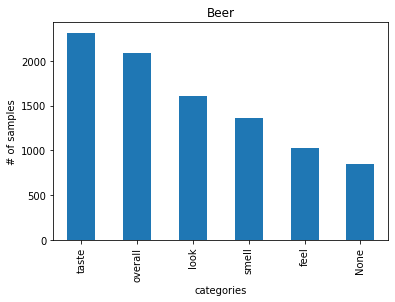

In [7]:
# pd.Series(labels).value_counts().plot(kind ='bar')
ax = pd.Series(labels).value_counts().plot(kind ='bar', title='Beer')
ax.set_xlabel("categories")
ax.set_ylabel("# of samples")

In [8]:
print(len(text))
print(len(labels))
print(text[0])

9235
9235
beer tap small pancake house amsterdam served amstel bock snifter


Classification: 100%|██████████| 1847/1847 [00:00<00:00, 41189.72it/s]



              precision    recall  f1-score   support

        None       0.70      0.65      0.68       173
        feel       0.76      0.81      0.78       204
        look       0.93      0.86      0.89       330
     overall       0.72      0.72      0.72       415
       smell       0.76      0.82      0.79       277
       taste       0.73      0.73      0.73       448

    accuracy                           0.77      1847
   macro avg       0.77      0.77      0.77      1847
weighted avg       0.77      0.77      0.77      1847


 Accuracy: 0.767

[ updating evaluations cache ]


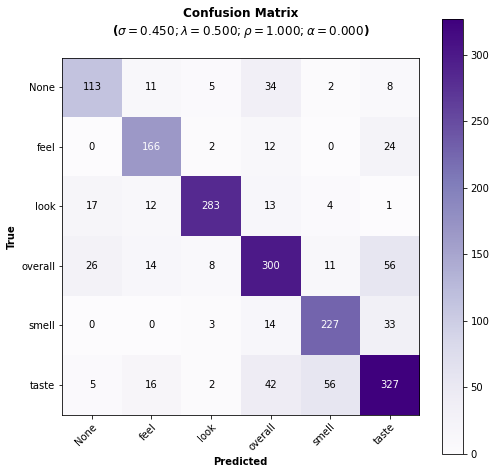

0.7657480800633607

In [9]:
clf = SS3(cv_m='gv')
clf.fit(X_train, y_train)
Evaluation.test(clf, X_val, y_val, metric="f1-score")

In [10]:
clf.print_categories_info()
clf.save_vocab(path='./vocab_beer')



 CATEGORIES:

	Category | Index |   Length   | Vocab. Size | Word Max. Fr. | N-gram |
	---------|-------|------------|-------------|---------------|--------|
	  None   |   0   |    3801    |    1434     |      168      |   1    |
	  feel   |   1   |    4784    |     982     |      261      |   1    |
	  look   |   2   |    9702    |    1503     |      739      |   1    |
	overall  |   3   |   10648    |    2493     |      388      |   1    |
	 smell   |   4   |    7217    |    1488     |      292      |   1    |
	 taste   |   5   |   13049    |    2353     |      489      |   1    |

	Most Probable Category: taste (26.52%)



In [11]:
vocab = {}
categories = list(set(labels))
grams = ["words"]
for gram in grams:
  for cat in categories:
    vocab[cat + '_' + gram] = pd.read_csv("/content/vocab_beer/ss3_vocab_"+ cat +"(" + gram + ").csv")

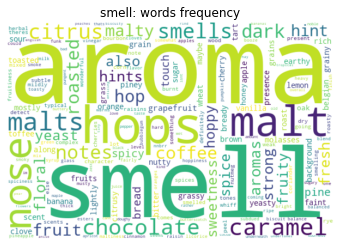

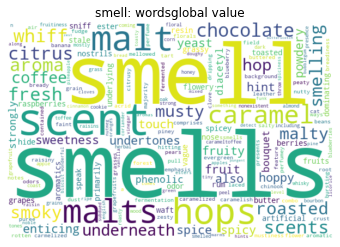

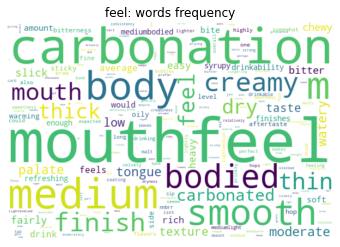

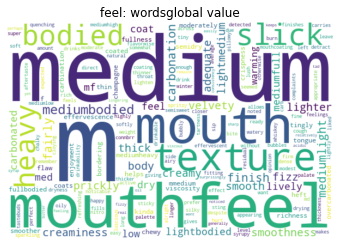

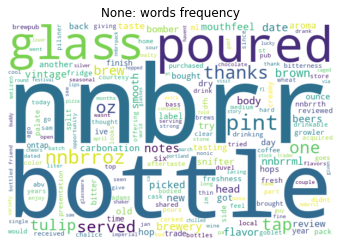

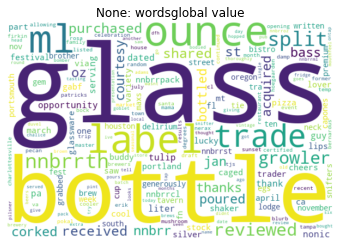

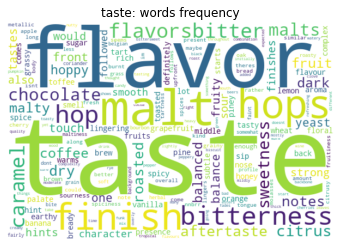

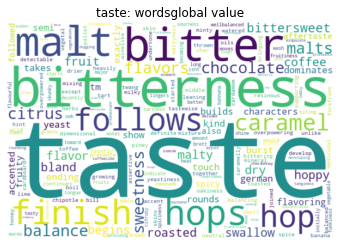

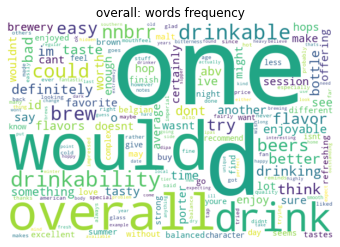

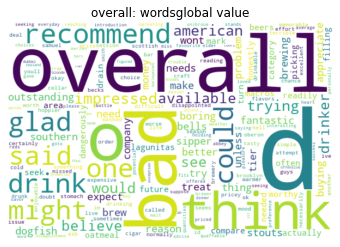

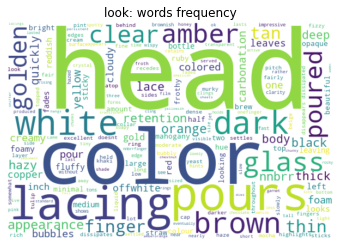

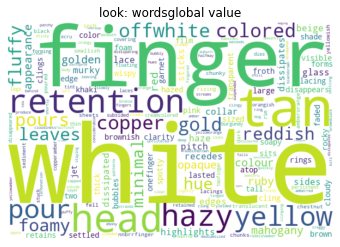

In [12]:
for cat in categories:
    for gram in ["words"]:
        for col in ["fr", "gv"]:
            df = vocab[cat + '_' + gram]
            df1 = df[["term",col]]
            count = df1.set_index('term').T.to_dict('records')[0]

            wordcloud = WordCloud(height =400,width = 600,max_font_size = 200,background_color="white").generate_from_frequencies(count)
            plt.figure()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.title(cat + ": " + gram + " frequency") if col == "fr" else plt.title(cat + ": " + gram + "global value")
            plt.axis("off")
            plt.show()

In [13]:
for cat in categories:
  for gram in ["words"]:
    df = vocab[cat + '_' + gram]
    above_threshold = df[df.gv > 0.2].count()["term"]
    total = df.describe()["fr"]["count"]
    percentage = (above_threshold/total)*100
    print(cat,"_", gram ,":         percentage=", round(percentage,2),", above threshold=", above_threshold,", total=", total)
  print("            ")  
  

smell _ words :         percentage= 2.32 , above threshold= 14 , total= 604.0
            
feel _ words :         percentage= 3.51 , above threshold= 13 , total= 370.0
            
None _ words :         percentage= 4.36 , above threshold= 21 , total= 482.0
            
taste _ words :         percentage= 1.07 , above threshold= 11 , total= 1025.0
            
overall _ words :         percentage= 1.51 , above threshold= 16 , total= 1061.0
            
look _ words :         percentage= 4.13 , above threshold= 25 , total= 605.0
            


In [14]:
# important_words = avg_important_word_number(X_train, y_train, vocab, 0.2)

In [15]:
# words = util.avg_word_number(X_train, y_train)

In [16]:
# print("percentage of average important words per sample: ", (important_words/words)*100)

In [17]:
fn_word = __false_negative_words__(clf, categories, X_val, y_val, vocab)

Classification: 100%|██████████| 1847/1847 [00:00<00:00, 38978.01it/s]


In [21]:
true_class = 'smell'
fn_class = 'taste'
## word frequency in false_negative class ##
a = fn_word[true_class][1]
b = a[a.fn_class == fn_class].groupby(['fn_word','fn_class'], as_index=False).agg({'count': sum}).sort_values('count', ascending=False)

In [22]:
a[a.fn_class == fn_class]

,sentence,fn_word,cv,fn_class,count,cv_trueclass
0,peat found though make late appearance taste,found,0.029492,taste,1,0.000000e+00
1,peat found though make late appearance taste,taste,0.730205,taste,1,1.281900e-07
2,peat found though make late appearance taste,peat,0.083942,taste,1,0.000000e+00
3,peat found though make late appearance taste,make,0.033036,taste,1,8.768257e-05
4,standard nose pumpkin ale overly spiced many,pumpkin,0.037588,taste,1,3.719439e-02
...,...,...,...,...,...,...
170,warms black malt aromas come bit,warms,0.098834,taste,1,7.740901e-02
171,warms black malt aromas come bit,aromas,0.027559,taste,1,8.610594e-02
172,warms black malt aromas come bit,malt,0.289409,taste,1,2.982038e-01
173,warms black malt aromas come bit,black,0.047144,taste,1,1.915705e-02


In [23]:
a[a.fn_class == fn_class].sentence.unique()

array(['peat found though make late appearance taste',
       'standard nose pumpkin ale overly spiced many',
       'smell fresh surprisingly bitter hoppy little bit sweetness balancing everything',
       'citrus notes acidity definitely noticeable beer',
       'mildly sweet corny smell consistant lager taste',
       'cocoa mostly sharp notes finish',
       'quite overwhelming exactly faint bourbon oak front',
       'toward bottom aroma started get sour',
       'aroma comprise mostly soapy resiny hops far punch face west coast bitterness impressive compared others within style',
       'strong ginger spiced meet honeylike flavors',
       'aroma malty sweet bitter',
       'coriander wheat lemons earthy presence',
       'thick citrus plentiful biting', 'light orangy hop notes',
       'fruity vinousness reminiscent slightly shiraz also flavors found chocolate 70 percent',
       'coriander orange peel cardamon slight cracked pepper accent triple type nose',
       'smell rich m

In [ ]:
# a[(a.sentence == 'finish characteristic')].sort_values('gv', ascending=False)

In [ ]:
# c = b[['fn_word','count']].set_index('fn_word', inplace=False)
# true_vocab = vocab[true_class + '_words'].sort_values('gv', ascending=False).set_index('term', inplace=False)
# false_vocab = vocab[fn_class + '_words'].sort_values('gv', ascending=False).set_index('term', inplace=False)

# result = pd.concat([c, false_vocab, true_vocab], axis=1, sort=False)

In [ ]:
# result.columns = ['count', fn_class +'_fr', fn_class +'_gv', fn_class +'_cv', true_class +'_fr', true_class +'_gv', true_class +'_cv']
# result[(~result['count'].isnull()) & (result[fn_class +'_gv'] > result[true_class + '_gv'])]
# # result[~result['count'].isnull()]

In [ ]:
# result[(~result['count'].isnull()) & (result[true_class + '_gv'].isnull())]

In [ ]:
!rm -rf vocab_beer

**ALL METRICS**

In [ ]:
# ### from all metrics notebook ###

# !rm -rf vocab && mkdir vocab
# util = reload(util)
# print("Avg Number of Sentences", util.avg_sent_number(X_train, y_train))
# print("Avg Number of Paragraphs", util.avg_para_number(X_train, y_train))
# overlap, counter, ratio = util.calc_overlap(clf, './vocab', 'fr')
# print("Overlap Ratio All Words", ratio)

# !rm -rf vocab_five && mkdir vocab_five
# overlap, counter, ratio = util.calc_overlap(clf, './vocab', 'gv', True, 0.2)
# print("Overlap Ratio Important Words", ratio)

Avg Number of Words 6.687195452084461
Avg Number of Sentences 1.0
Avg Number of Paragraphs 1.0
Overlap Ratio All Words 0.45794392523364486
Overlap Ratio Important Words 0.04494882064975523
